In [209]:
img, tar = train_dataset[6]
tar

tensor([0.7222, 1.5241, 2.7389, 1.9621])

In [210]:
class BoxRegressorCNN(nn.Module):
    def __init__(self):
        super(BoxRegressorCNN, self).__init__()
        self.features_ext = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), #90 145
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), #45 73
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), #23 37
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), #12 19
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), #12 19
            nn.ReLU(),
            )

        self.adapt = nn.AdaptiveAvgPool2d((4,4))

        self.linear = nn.Sequential(
            # nn.Linear(256*4*19, 1024),
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),

            )

        self.result = nn.Linear(256, 4)


    def forward(self, x):
        x = self.features_ext(x)
        x = self.adapt(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)# flatten all dimensions except batch
        out = self.result(x)
        return out

model = BoxRegressorCNN()
# device = xm.xla_device() # TPU
# model.to(device)

In [211]:
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [212]:
# TPU
# import torch_xla
# import torch_xla.core.xla_model as xm


def train_model(model, trainloader, testloader, epochs=10, device=None):
    try:
        device = xm.xla_device()  # TPU замість CUDA
        model.to(device)
    except:
        device = 'cpu'

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for imgs, targets in trainloader:
            imgs, targets = imgs.to(device), targets.to(device)

            preds = model(imgs)            # [B, 4]
            loss = criterion(preds, targets)

            optimizer.zero_grad()
            loss.backward()
            # xm.optimizer_step(optimizer)   # TPU
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)

        # середній train loss
        train_loss /= len(trainloader.dataset)

        # валідація
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, targets in testloader:
                imgs, targets = imgs.to(device), targets.to(device)
                preds = model(imgs)
                loss = criterion(preds, targets)
                val_loss += loss.item() * imgs.size(0)

        val_loss /= len(testloader.dataset)

        # xm.master_print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}") # TPU
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}") # CPU


    return model

In [187]:
device = 'cpu'
imgs, targets = next(iter(testloader))

imgs, targets = imgs.to(device), targets.to(device)

model.eval()
with torch.no_grad():
    preds = model(imgs)

print(preds.shape)

torch.Size([128, 4])


In [214]:
train_model(model, trainloader, testloader, epochs=10)

Epoch 1/10 | Train Loss: 1.3554 | Val Loss: 1.3164
Epoch 2/10 | Train Loss: 1.2304 | Val Loss: 0.9024
Epoch 3/10 | Train Loss: 0.5222 | Val Loss: 0.2996
Epoch 4/10 | Train Loss: 0.1919 | Val Loss: 0.2139
Epoch 5/10 | Train Loss: 0.1469 | Val Loss: 0.1381
Epoch 6/10 | Train Loss: 0.1063 | Val Loss: 0.1083
Epoch 7/10 | Train Loss: 0.0834 | Val Loss: 0.0874
Epoch 8/10 | Train Loss: 0.0736 | Val Loss: 0.0808
Epoch 9/10 | Train Loss: 0.0651 | Val Loss: 0.0705
Epoch 10/10 | Train Loss: 0.0600 | Val Loss: 0.0683


BoxRegressorCNN(
  (features_ext): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
  )
  (adapt): AdaptiveAvgPool2d(output_size=(4, 4))
  (linear): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
  )
  (result): Linear(in_features=256, out_features=4, bias=True)
)

In [215]:
test_path_1 = r'Volkswagen-Tiguan-2024-1280-0b-3885198800.jpg'
test_path_2 = r'19052113091410800-2701041027.jpg'
test_path_3 = r'image17816-scaled-1660724155.jpg'

In [ ]:
from google.colab import files
files.upload()

(186, 461) (499, 547)


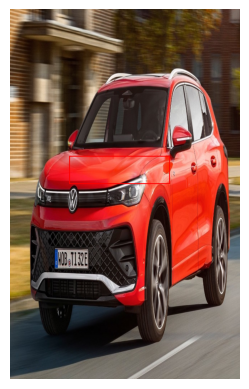

(155, 386) (415, 453)


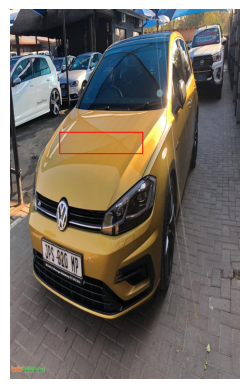

(187, 464) (503, 549)


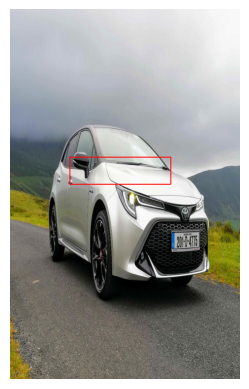

In [218]:
pred_1 = predict_and_draw(model, test_path_1)
pred_2 = predict_and_draw(model, test_path_2)
pred_3 = predict_and_draw(model, test_path_3)


In [219]:
pred_1, pred_2, pred_3

(tensor([1.0374, 1.5916, 2.7768, 1.8894]),
 tensor([0.8665, 1.3318, 2.3107, 1.5638]),
 tensor([1.0422, 1.6023, 2.7953, 1.8952]))